# Kaggle Dog Bred Classifier

 
 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np




In [2]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.visible_device_list = "0"

set_session(tf.Session(config=config))

num_cores = 1


config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
        device_count = {'CPU' : 1, 'GPU' : 1})  #GPUs set to zero so we only use CPU
session = tf.Session(config=config)
set_session(session)



Using TensorFlow backend.


In [3]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, GlobalAveragePooling2D
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

from keras.applications import Xception


In [4]:
from io import BytesIO
import os
import cv2
from tqdm import tqdm

import re

import time
from datetime import timedelta

import PIL.Image

from scipy.stats import itemfreq
import scipy.io as sio

from sklearn.model_selection import train_test_split


## Import data - taken from a Kaggle kernel example

### Set up the import

In [5]:
stanford_list_path = "./lists/file_list.mat"
file_list = sio.loadmat(stanford_list_path)

In [6]:
file_list['labels'].size


20580

In [7]:
#f = file_list['file_list']
#print(f)
#f = np.squeeze(f)
#f

In [8]:
image_list = []
for root, directories, filenames in os.walk('./Images'):
    image_list.extend([os.path.join(root,filename) for filename in filenames])

# Delete the 'DS_Store' item from the list, on Macs
del image_list[0]
print(image_list)

['./Images/n02085620-Chihuahua/n02085620_10074.jpg', './Images/n02085620-Chihuahua/n02085620_10131.jpg', './Images/n02085620-Chihuahua/n02085620_10621.jpg', './Images/n02085620-Chihuahua/n02085620_1073.jpg', './Images/n02085620-Chihuahua/n02085620_10976.jpg', './Images/n02085620-Chihuahua/n02085620_11140.jpg', './Images/n02085620-Chihuahua/n02085620_11238.jpg', './Images/n02085620-Chihuahua/n02085620_11258.jpg', './Images/n02085620-Chihuahua/n02085620_11337.jpg', './Images/n02085620-Chihuahua/n02085620_11477.jpg', './Images/n02085620-Chihuahua/n02085620_1152.jpg', './Images/n02085620-Chihuahua/n02085620_11696.jpg', './Images/n02085620-Chihuahua/n02085620_11818.jpg', './Images/n02085620-Chihuahua/n02085620_11948.jpg', './Images/n02085620-Chihuahua/n02085620_1205.jpg', './Images/n02085620-Chihuahua/n02085620_12101.jpg', './Images/n02085620-Chihuahua/n02085620_12334.jpg', './Images/n02085620-Chihuahua/n02085620_1235.jpg', './Images/n02085620-Chihuahua/n02085620_1271.jpg', './Images/n02085

In [9]:
dog_pattern = re.compile(r'(?<=-)[^\/]+')
file_names = list()
dog_names = list()
for name in image_list:
    #print(name)
    file_names.append(name)
    match = dog_pattern.search(name)
    dog_names.append(match.group(0))
    #print(match)
    #dog_names.append(dog_pattern.search(name[0]).group(1))
#file_names = np.array(file_names)
print(file_names[20800],dog_names[20800])


./Images/n02117000-Labradoodle/379.jpg Labradoodle


In [10]:
l = file_list['labels']
labels = list()
for name in l:
    labels.append(name[0])

dog_name_list = dict(list(zip(labels,dog_names)))
print(dog_name_list)


{1: 'Chihuahua', 2: 'Japanese_spaniel', 3: 'Maltese_dog', 4: 'Pekinese', 5: 'Shih-Tzu', 6: 'Blenheim_spaniel', 7: 'papillon', 8: 'toy_terrier', 9: 'Rhodesian_ridgeback', 10: 'Afghan_hound', 11: 'basset', 12: 'beagle', 13: 'bloodhound', 14: 'bluetick', 15: 'black-and-tan_coonhound', 16: 'Walker_hound', 17: 'English_foxhound', 18: 'redbone', 19: 'borzoi', 20: 'Irish_wolfhound', 21: 'Italian_greyhound', 22: 'whippet', 23: 'Ibizan_hound', 24: 'Norwegian_elkhound', 25: 'otterhound', 26: 'Saluki', 27: 'Scottish_deerhound', 28: 'Weimaraner', 29: 'Staffordshire_bullterrier', 30: 'American_Staffordshire_terrier', 31: 'Bedlington_terrier', 32: 'Border_terrier', 33: 'Kerry_blue_terrier', 34: 'Irish_terrier', 35: 'Norfolk_terrier', 36: 'Norwich_terrier', 37: 'Yorkshire_terrier', 38: 'wire-haired_fox_terrier', 39: 'Lakeland_terrier', 40: 'Sealyham_terrier', 41: 'Airedale', 42: 'cairn', 43: 'Australian_terrier', 44: 'Dandie_Dinmont', 45: 'Boston_bull', 46: 'miniature_schnauzer', 47: 'giant_schnauzer

In [11]:
dog_name_list[121] = 'Labradoodle' 

In [12]:
dog_name_list

{1: 'Chihuahua',
 2: 'Japanese_spaniel',
 3: 'Maltese_dog',
 4: 'Pekinese',
 5: 'Shih-Tzu',
 6: 'Blenheim_spaniel',
 7: 'papillon',
 8: 'toy_terrier',
 9: 'Rhodesian_ridgeback',
 10: 'Afghan_hound',
 11: 'basset',
 12: 'beagle',
 13: 'bloodhound',
 14: 'bluetick',
 15: 'black-and-tan_coonhound',
 16: 'Walker_hound',
 17: 'English_foxhound',
 18: 'redbone',
 19: 'borzoi',
 20: 'Irish_wolfhound',
 21: 'Italian_greyhound',
 22: 'whippet',
 23: 'Ibizan_hound',
 24: 'Norwegian_elkhound',
 25: 'otterhound',
 26: 'Saluki',
 27: 'Scottish_deerhound',
 28: 'Weimaraner',
 29: 'Staffordshire_bullterrier',
 30: 'American_Staffordshire_terrier',
 31: 'Bedlington_terrier',
 32: 'Border_terrier',
 33: 'Kerry_blue_terrier',
 34: 'Irish_terrier',
 35: 'Norfolk_terrier',
 36: 'Norwich_terrier',
 37: 'Yorkshire_terrier',
 38: 'wire-haired_fox_terrier',
 39: 'Lakeland_terrier',
 40: 'Sealyham_terrier',
 41: 'Airedale',
 42: 'cairn',
 43: 'Australian_terrier',
 44: 'Dandie_Dinmont',
 45: 'Boston_bull',
 46

In [13]:

#labels = pd.DataFrame(list(zip(file_names,dog_names,labels)), columns = ['file','breed', 'label'])
labels_raw = pd.DataFrame(list(zip(file_names,dog_names)), columns = ['file','breed'])
labels_raw.sample(5)
#labels[200]
#file = './' + labels[200][0]
#print(file)

,file,breed
4236,./Images/n02091467-Norwegian_elkhound/n0209146...,Norwegian_elkhound
20398,./Images/n02115913-dhole/n02115913_5593.jpg,dhole
15555,./Images/n02108000-EntleBucher/n02108000_944.jpg,EntleBucher
18648,./Images/n02112137-chow/n02112137_10605.jpg,chow
16512,./Images/n02109961-Eskimo_dog/n02109961_10699.jpg,Eskimo_dog


## Create one-hot lables and load data

In [14]:
targets_series = pd.Series(labels_raw['breed'])
one_hot = pd.get_dummies(targets_series, sparse = True)

#### Define target image size

In [15]:
image_resize = 150
X = []
y = []
X_TESTING = []
Train = []
Train_labels = []

In [16]:
labels_raw.iloc[20580]

file     ./Images/n02117000-Labradoodle/100.jpg
breed                               Labradoodle
Name: 20580, dtype: object

#### Load X

In [17]:
i = 0 
for f, breed in tqdm(labels_raw.values):
    img = cv2.imread(f)
 #   label = one_hot_labels[i]
    Train.append(cv2.resize(img, (image_resize, image_resize)))
 #   Train_labels.append(label)
    i += 1

100%|██████████| 20995/20995 [02:26<00:00, 143.05it/s]


In [18]:
type(Train)

list

In [19]:
#y_raw = np.array(Train_labels, np.uint8)
X_raw = np.array(Train, np.float32) / 255.


In [20]:
Train = []

In [21]:
print(X_raw.shape)
#print(y_raw.shape)


(20995, 150, 150, 3)


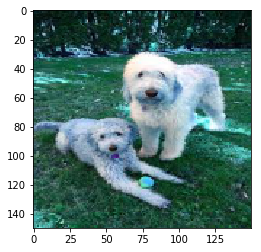

In [22]:
#let's check one image from the train data base
lum_img = X_raw[20600,:,:,:]
plt.imshow(lum_img)
plt.show()

## Limit the number of Dog Breeds in the data in order to simplify the initial calcs

In [23]:
Nber_of_breeds = 121

#######Get the N most represented breeds########
def main_breeds(labels_raw, Nber_breeds , all_breeds='TRUE'):
    labels_freq_pd = itemfreq(labels_raw["breed"])
    labels_freq_pd = labels_freq_pd[labels_freq_pd[:, 1].argsort()[::-1]] #[::-1] ==> to sort in descending order
#    print ('Item frequency:')
#    print (labels_freq_pd)
    if all_breeds == 'FALSE':
        main_labels = labels_freq_pd[:,0][0:Nber_breeds]
    else: 
        main_labels = labels_freq_pd[:,0][:]
        
    labels_raw_np = labels_raw["breed"].as_matrix() #transform in numpy
    labels_raw_np = labels_raw_np.reshape(labels_raw_np.shape[0],1)

    labels_filtered_index = np.where(labels_raw_np == main_labels)
    
    return labels_filtered_index

if Nber_of_breeds < 121:
    labels_filtered_index = main_breeds(labels_raw = labels_raw, Nber_breeds = Nber_of_breeds, all_breeds='FALSE')
    labels_filtered = labels_raw.iloc[labels_filtered_index[0],:]
    train_filtered = X_raw[labels_filtered_index[0],:,:,:]
    print('- Number of images remaining after selecting the {0} main breeds : {1}'.format(Nber_of_breeds, labels_filtered_index[0].shape))

else:
    train_filtered = X_raw
    labels_filtered = labels_raw
    X_raw = []

print('- The shape of train_filtered dataset is : {0}'.format(train_filtered.shape))

- The shape of train_filtered dataset is : (20995, 150, 150, 3)


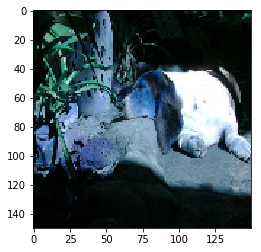

In [24]:
#let's check one image from the train data base
lum_img = train_filtered[2000,:,:,:]
plt.imshow(lum_img)
plt.show()

#### Load the lables

### Create 'One-Hot' labels for the data

In [25]:
#We select the labels from the N main breeds
labels = labels_filtered["breed"].as_matrix()
labels = labels.reshape(labels.shape[0],1) #labels.shape[0] looks faster than using len(labels)
labels.shape

(20995, 1)

In [26]:
#Function to create one-hot labels
def matrix_Bin(labels):
    labels_bin=np.array([])

    labels_name, labels0 = np.unique(labels, return_inverse=True)
    labels0
    
    for _, i in enumerate(itemfreq(labels0)[:,0].astype(int)):
        labels_bin0 = np.where(labels0 == itemfreq(labels0)[:,0][i], 1., 0.)
        labels_bin0 = labels_bin0.reshape(1,labels_bin0.shape[0])

        if (labels_bin.shape[0] == 0):
            labels_bin = labels_bin0
        else:
            labels_bin = np.concatenate((labels_bin,labels_bin0 ),axis=0)

    print("Nber SubVariables {0}".format(itemfreq(labels0)[:,0].shape[0]))
    labels_bin = labels_bin.transpose()
    print("Shape : {0}".format(labels_bin.shape))
    
    return labels_name, labels_bin

In [30]:
labels_name, labels_bin = matrix_Bin(labels = labels)
labels_bin[-2:]

Nber SubVariables 121
Shape : (20995, 121)


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.,

In [32]:
for breed in range(len(labels_name)):
    print('Breed {0} : {1}'.format(breed,labels_name[breed]))
labels[-10:]

Breed 0 : Afghan_hound
Breed 1 : African_hunting_dog
Breed 2 : Airedale
Breed 3 : American_Staffordshire_terrier
Breed 4 : Appenzeller
Breed 5 : Australian_terrier
Breed 6 : Bedlington_terrier
Breed 7 : Bernese_mountain_dog
Breed 8 : Blenheim_spaniel
Breed 9 : Border_collie
Breed 10 : Border_terrier
Breed 11 : Boston_bull
Breed 12 : Bouvier_des_Flandres
Breed 13 : Brabancon_griffon
Breed 14 : Brittany_spaniel
Breed 15 : Cardigan
Breed 16 : Chesapeake_Bay_retriever
Breed 17 : Chihuahua
Breed 18 : Dandie_Dinmont
Breed 19 : Doberman
Breed 20 : English_foxhound
Breed 21 : English_setter
Breed 22 : English_springer
Breed 23 : EntleBucher
Breed 24 : Eskimo_dog
Breed 25 : French_bulldog
Breed 26 : German_shepherd
Breed 27 : German_short-haired_pointer
Breed 28 : Gordon_setter
Breed 29 : Great_Dane
Breed 30 : Great_Pyrenees
Breed 31 : Greater_Swiss_Mountain_dog
Breed 32 : Ibizan_hound
Breed 33 : Irish_setter
Breed 34 : Irish_terrier
Breed 35 : Irish_water_spaniel
Breed 36 : Irish_wolfhound
Bre

array([['Labradoodle'],
       ['Labradoodle'],
       ['Labradoodle'],
       ['Labradoodle'],
       ['Labradoodle'],
       ['Labradoodle'],
       ['Labradoodle'],
       ['Labradoodle'],
       ['Labradoodle'],
       ['Labradoodle']], dtype=object)

# Create Test/Train data


In [33]:
Train = []

In [34]:
X_raw = []

In [35]:
X_train, X_test, y_train, y_test = train_test_split(train_filtered, labels_bin, test_size=0.05, random_state=50)
X_train.shape

(19945, 150, 150, 3)

In [36]:
y_train.shape

(19945, 121)

In [37]:
y_test.shape

(1050, 121)

In [38]:
train_filtered = []

# Create the Keras model

In [39]:
base_model = Xception(input_shape=(image_resize, image_resize, 3), weights='imagenet', include_top=False)

In [40]:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

0 input_1
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_1
13 block2_pool
14 batch_normalization_1
15 add_1
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_2
23 block3_pool
24 batch_normalization_2
25 add_2
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_3
33 block4_pool
34 batch_normalization_3
35 add_3
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_4
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_sepcon

In [41]:
print(base_model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 74, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 74, 74, 32)   0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [42]:
# Top Model Block
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(Nber_of_breeds, activation='softmax')(x)

# add your top layer block to your base model
model = Model(base_model.input, predictions)
print(model.summary())


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 74, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 74, 74, 32)   0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

## First, we just train the top layers in order to get those stable first.  After this, we will unfreeze some more and retrain those

In [43]:
# Freeze pre-trained layers
for layer in base_model.layers:
    layer.trainable = False


### Augmentation - taken from an MNIST CNN kernel 

In [44]:
datagen = ImageDataGenerator(zoom_range = 0.1,
                            height_shift_range = 0.1,
                            width_shift_range = 0.1,
                            horizontal_flip = True,
                            vertical_flip = True,
                            rotation_range = 90)

In [45]:
annealer = LearningRateScheduler(lambda x: 1e-4 * 0.9 ** x)

#### Compile it

In [48]:
model.compile(loss='categorical_crossentropy', optimizer = Adam(lr=1e-5), metrics=["accuracy"])
#model.compile(loss='categorical_crossentropy', optimizer = SGD(lr=1e-4, momentum=0.9, decay=0.00, nesterov=True), metrics=["accuracy"])
#keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)

### Run it!

In [ ]:
hist = model.fit_generator(datagen.flow(X_train, y_train, batch_size=32),
                           #steps_per_epoch=500,
                           epochs=5, #Increase this when not on Kaggle kernel  WAS SET TO 20 originally
                           verbose=2,  #1 for ETA, 0 for silent
                           #validation_data=(x_val[:400,:], y_val[:400,:]), #For speed
                           validation_data=(X_test[:250,:], y_test[:250,:]), 
                           #initial_epoch = 1,                           
                           callbacks=[annealer]
                          )

## The top layers are now trained, so we go back and unfreeze the last Xception block to train further

In [ ]:
# we chose to train the top 1 xception block, i.e. we will freeze
# the first 126 layers (0-125) and unfreeze the rest:
for layer in model.layers[:126]:
   layer.trainable = False
for layer in model.layers[126:]:
   layer.trainable = True

In [ ]:
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9, nesterov=True), loss='categorical_crossentropy', metrics=["accuracy"])


In [ ]:
hist = model.fit_generator(datagen.flow(X_train, y_train, batch_size=32),
                           #steps_per_epoch=500,
                           epochs=50, #Increase this when not on Kaggle kernel  WAS SET TO 20 originally
                           verbose=2,  #1 for ETA, 0 for silent
                           #validation_data=(x_val[:400,:], y_val[:400,:]), #For speed
                           validation_data=(X_test[:250,:], y_test[:250,:]) 
                           #,initial_epoch = 1                           
                           #,callbacks=[annealer]
                          )

## Evaluate

We only used a subset of the validation set during training, to save time. Now let's check performance on the whole validation set.


In [ ]:

final_loss, final_acc = model.evaluate(X_test, y_test, verbose=0)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))


In [ ]:

plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['acc'], color='b')
plt.plot(hist.history['val_acc'], color='r')
plt.show()

In [ ]:
model.summary()

In [ ]:
model.summary()

#### Load X_TESTING

In [ ]:
#for f in tqdm(df_submission['id'].values):
#    img = cv2.imread('../input/test/{}.jpg'.format(f))
#    X_TESTING.append(cv2.resize(img, (im_size, im_size)))
#X_TESTING  = np.array(x_test, np.float32) / 255.

In [ ]:
#for f in tqdm(df_submission['id'].values):
X_TESTING = []
img = cv2.imread('./Henry_cropped.jpg')
X_TESTING.append(cv2.resize(img, (image_resize, image_resize)))
img = cv2.imread('./Henry2.jpg')
X_TESTING.append(cv2.resize(img, (image_resize, image_resize)))
img = cv2.imread('./Henry3.jpg')
X_TESTING.append(cv2.resize(img, (image_resize, image_resize)))
img = cv2.imread('./Henry4.jpg')
X_TESTING.append(cv2.resize(img, (image_resize, image_resize)))
img = cv2.imread('./Henry5.jpg')
X_TESTING.append(cv2.resize(img, (image_resize, image_resize)))
img = cv2.imread('./Henry7.jpg')
X_TESTING.append(cv2.resize(img, (image_resize, image_resize)))
img = cv2.imread('./Calendar/Amanda.jpg')
X_TESTING.append(cv2.resize(img, (image_resize, image_resize)))
img = cv2.imread('./Calendar/Corinne.jpg')
X_TESTING.append(cv2.resize(img, (image_resize, image_resize)))
img = cv2.imread('./Calendar/Jing.jpg')
X_TESTING.append(cv2.resize(img, (image_resize, image_resize)))
img = cv2.imread('./Calendar/Karen.jpg')
X_TESTING.append(cv2.resize(img, (image_resize, image_resize)))
img = cv2.imread('./Calendar/Labrador.jpg')
X_TESTING.append(cv2.resize(img, (image_resize, image_resize)))
img = cv2.imread('./Calendar/Pam.jpg')
X_TESTING.append(cv2.resize(img, (image_resize, image_resize)))
X_TESTING  = np.array(X_TESTING, np.float32) / 255.

In [ ]:
prediction = model.predict(X_TESTING, verbose=1)

In [ ]:
sub = pd.DataFrame(prediction)
# Set column names to those generated by the one-hot encoding earlier
col_names = one_hot.columns.values
sub.columns = col_names
# Insert the column id from the sample_submission at the start of the data frame
#sub.insert(0, 'id', labels_raw['id'])
actual_names = ['Henry1','Henry2','Henry3','Henry4','Henry5','Henry7', 'Amanda','Corinne','Jing','Karen','Labrador','Pam']
sub.insert(0, 'id', actual_names)

sub

In [ ]:
sub = sub.set_index('id')
sub


In [ ]:
nlargest = 10
order = np.argsort(-sub.values, axis=1)[:, :nlargest]
result = pd.DataFrame(sub.columns[order], 
                      columns=['top{}'.format(i) for i in range(1, nlargest+1)],
                      index=sub.index)

print(result)

In [ ]:
model.save('dog_classifier.h5')